## Amazon Stock Forecasting in PyTorch with LSTM Neural Network

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
 
import torch
import torch.nn as nn

data = pd.read_csv('AMZN.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [2]:
data = data[['Date','Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data['Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 6516 entries, 0 to 6515
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
6516 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 51.0 KB


C:\Users\ivoto\AppData\Local\Temp\ipykernel_19000\4140636855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


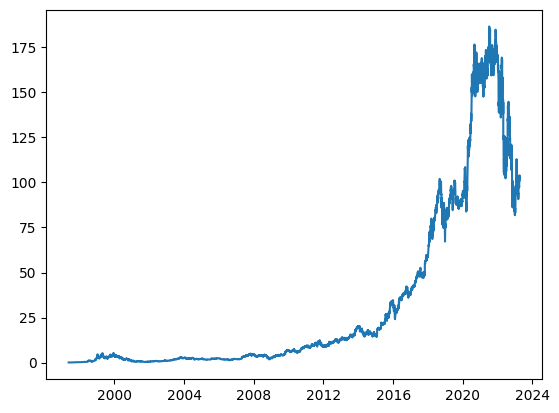

In [5]:
plt.plot(data['Date'],data['Close'])

In [6]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


En el cuadro aterior vemos para el dia actual, y los precios de los 7 (n-dias) anteriores

In [7]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [8]:
#Normalizamos los datos 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np.shape

(6509, 8)

- Hasta ahora, leemos el CSV, lo convertimos a DataFrame con pandas
- Luego lo analizamos y para trabajar con el lo pasamos de DataFrame a una matriz de NumPy 
- Y por ultimo Escalamos las variables con un rango de -1 a 1 

#### Division del conjunto de entrenamiento y test

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6509, 7), (6509,))

In [10]:
X = dc(np.flip(X, axis=1 ))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [11]:
split_index = int(len(X) * 0.95)

split_index

6183

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

#### Agregamos un dimension

In [13]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

#### Convertimos a los conjuntos a Tensores de Pytorch 

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
x_sample, y_sample = train_dataset[10]
print(x_sample.shape)  # Imprimirá torch.Size([7, 1])
print(y_sample.shape)  # Imprimirá torch.Size([1])

torch.Size([7, 1])
torch.Size([1])


In [17]:
from torch.utils.data import DataLoader

batch_size = 16 
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


#### Creamos el modelo

In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

#### Funcion y Bucle de entrenamiento 

In [20]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) #Pasamos el conjunto de train con sus etiquetas

        output = model(x_batch) 
        loss = loss_function(output, y_batch) #Calculamos el loss con el valor pred y el real
        running_loss += loss.item() #Perdida acumulada 

        optimizer.zero_grad() #Seteamos los gradientes en cero
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99: #Print every 100 batches 
            avg_loss_across_batches = running_loss / 100 #Perdida promedio en 100 lotes 
            print('Batch {0}, loss: {1:.3}'.format(batch_index+1, avg_loss_across_batches))
            running_loss = 0.0
    print()


In [21]:
def validate_one_epoch():
    model.train(False) #Evaluate mode
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) #Pasamos el conjunto de test con sus etiquetas

        with torch.no_grad(): #No necesitamos calcular los gradientes
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    
    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()


In [22]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, loss: 0.268
Batch 200, loss: 0.146
Batch 300, loss: 0.0835

Val Loss: 0.042
***************************************************

Epoch: 2
Batch 100, loss: 0.0114
Batch 200, loss: 0.00726
Batch 300, loss: 0.00492

Val Loss: 0.009
***************************************************

Epoch: 3
Batch 100, loss: 0.00197
Batch 200, loss: 0.00123
Batch 300, loss: 0.000779

Val Loss: 0.005
***************************************************

Epoch: 4
Batch 100, loss: 0.000501
Batch 200, loss: 0.00043
Batch 300, loss: 0.000322

Val Loss: 0.004
***************************************************

Epoch: 5
Batch 100, loss: 0.000324
Batch 200, loss: 0.000334
Batch 300, loss: 0.000352

Val Loss: 0.005
***************************************************

Epoch: 6
Batch 100, loss: 0.000265
Batch 200, loss: 0.000329
Batch 300, loss: 0.000327

Val Loss: 0.005
***************************************************

Epoch: 7
Batch 100, loss: 0.000284
Batch 200, loss: 0.000335
Batch 300, l

### Visualizacion

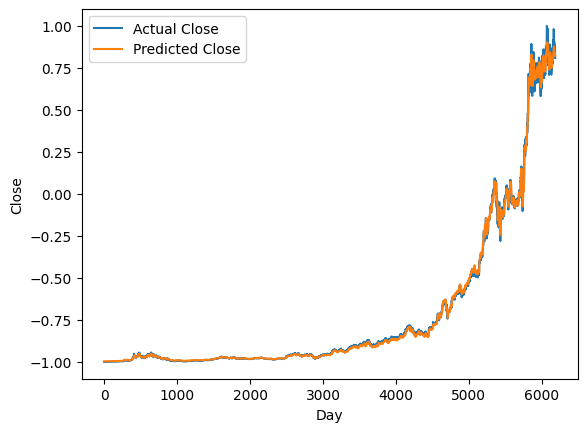

In [23]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy() #Es porque numpy no usa GPU 

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

##### Anti-transformada de los Precios 

In [24]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.43340604,   0.43315037,   0.4326946 , ..., 170.97124006,
       170.35920178, 170.10208301])

In [27]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

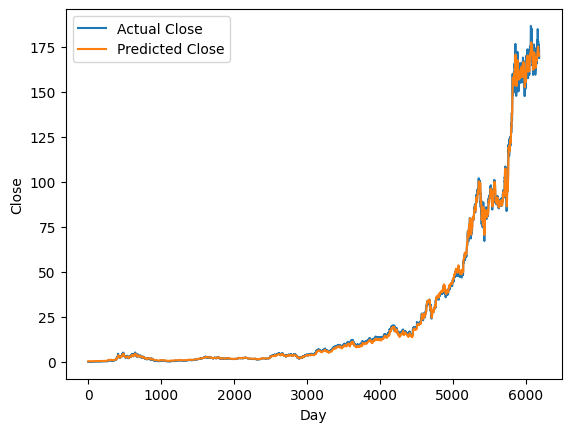

In [28]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [29]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([169.61369073, 169.2205758 , 168.70627156, 168.56243845,
       168.70148045, 168.87282627, 168.91033249, 169.03641295,
       169.00923373, 168.805862  , 168.29871662, 168.17865005,
       167.98043626, 167.3336486 , 166.45578752, 165.5508695 ,
       164.6041544 , 164.27504681, 164.32657061, 164.04887567,
       163.77474904, 163.12103595, 161.94117981, 159.93896602,
       156.28784053, 152.85583848, 149.25445262, 145.96246525,
       143.73986632, 143.46667901, 145.24731267, 147.65979376,
       149.76117559, 148.98594526, 150.78467061, 153.26434385,
       155.88684974, 158.16884833, 159.67204272, 159.717397  ,
       159.16544203, 158.60350467, 158.46640801, 158.02122458,
       157.25970614, 156.14920426, 154.00870437, 152.90867399,
       152.97215888, 153.49737927, 153.74920116, 154.04665523,
       153.55709575, 152.21470898, 149.06992294, 145.43008043,
       143.07455343, 143.35679492, 144.4094812 , 144.84291475,
       146.2285326 , 148.70778343, 151.68576464, 154.89

In [30]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 , 169.66949429, 170.66099675, 169.20100565,
       168.64449858, 166.71699707, 170.40449492, 167.52200227,
       164.35699578, 163.25399737, 162.55400179, 161.48599177,
       165.36199892, 165.20699954, 161.21400501, 162.13799851,
       158.91749416, 156.29899568, 151.66749509, 142.64300408,
       144.54400445, 139.98599336, 138.87249844, 139.63749627,
       143.97799855, 149.57350001, 151.19349835, 150.61250219,
       138.84550541, 157.63949825, 157.93550165, 161.41349717,
       161.18949925, 159.003495  , 153.29350176, 155.1670061 ,
       156.51049894, 158.10049453, 154.6524962 , 152.60149876,
       150.19749381, 144.82699629, 151.35800212, 153.78849709,
       153.56300403, 151.14199678, 152.05250627, 147.89849848,
       145.64100565, 137.45300383, 136.01449488, 139.27900567,
       146.81750468, 145.52450739, 141.8529947 , 147.36650272,
       153.10400311, 157.23899657, 161.25050521, 161.49

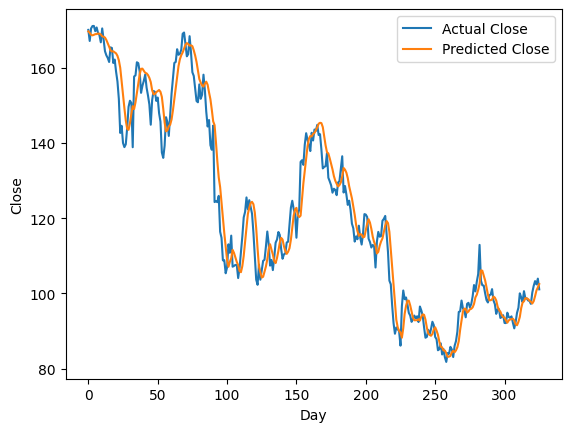

In [31]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()